In [ ]:
%matplotlib inline

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, Compose
import matplotlib.pyplot as plt

# architecture: https://github.com/AKASHKADEL/dcgan-mnist/blob/master/main.py

device = "cuda" if torch.cuda.is_available() else "cpu"

class GeneratorNet(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.net = nn.Sequential(
      nn.ConvTranspose2d(z_dim, 32*4, 4, 1, 0, bias=False),
      nn.BatchNorm2d(32*4), nn.ReLU(True),
      nn.ConvTranspose2d(32*4, 32*2, 3, 2, 1, bias=False),
      nn.BatchNorm2d(32*2), nn.ReLU(True),
      nn.ConvTranspose2d(32*2, 32, 4, 2, 1, bias=False),
      nn.BatchNorm2d(32), nn.ReLU(True),
      nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=False),
      nn.Sigmoid()
    )

  def forward(self, z):
    x = self.net(z)
    return x

class DiscriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
      nn.Conv2d(1, 32, 4, 2, 1, bias=False),
      nn.LeakyReLU(0.2, True),
      nn.Conv2d(32, 32 * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(32 * 2), nn.LeakyReLU(0.2, True),
      nn.Conv2d(32 * 2, 32 * 4, 3, 2, 1, bias=False),
      nn.BatchNorm2d(32 * 4), nn.LeakyReLU(0.2, True),
      nn.Conv2d(32 * 4, 1, 4, 1, 0, bias=False),
      nn.Sigmoid(), nn.Flatten(1)
    )

  def forward(self, x):
    return self.net(x).flatten(1)
    
criterion = nn.BCELoss()

def g_loss(x_fake, d):
  return criterion(d(x_fake), torch.ones(x_fake.size(0), device=x_fake.device).unsqueeze(1))

def d_loss(x_real, x_fake, d):
  return (criterion(d(x_real), torch.ones(x_real.size(0), device=x_fake.device).unsqueeze(1)) + criterion(d(x_fake), torch.zeros(x_real.size(0), device=x_fake.device).unsqueeze(1))) / 2

def train(batch_size=128, epochs=100, lr_g=2e-4, lr_d=2e-4, k=1, k2=1, z_dim=100, seed=42):
  torch.manual_seed(seed)
  X = datasets.MNIST(root="data", download=True, transform=ToTensor())
  dl = DataLoader(X, batch_size=batch_size, shuffle=True, drop_last=True)

  g_net = GeneratorNet(z_dim=z_dim).to(device)
  d_net = DiscriminatorNet().to(device)
  opt_g = torch.optim.Adam(g_net.parameters(), lr=lr_g)
  opt_d = torch.optim.Adam(d_net.parameters(), lr=lr_d)

  def sample_fake(m):
    z = torch.randn(m, z_dim, 1, 1, device=device)
    return g_net(z)

  losses_g = []
  losses_d = []
  running_loss_g = 0
  running_loss_d = 0
  last_epoch = 0
  for epoch in range(1, epochs + 1):
    g_net.train()
    d_net.train()
    epoch_loss_g = 0
    epoch_loss_d = 0
    for (x, _) in dl:
      x = x.to(device)
      m = batch_size
      for _ in range(k):
        x_fake = sample_fake(m)
        loss_d = d_loss(x, x_fake, d_net)
        epoch_loss_d += loss_d.item()
        opt_d.zero_grad()
        loss_d.backward()
        running_loss_d += loss_d.item()
        opt_d.step()
      for _ in range(k2):
        x_fake = sample_fake(m)
        loss_g = g_loss(x_fake, d_net)
        epoch_loss_g += loss_g.item()
        opt_g.zero_grad()
        loss_g.backward()
        running_loss_g += loss_g.item()
        opt_g.step()
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    def plot_losses():
      plt.figure(figsize=(2, 1.5))
      plt.plot(range(1, epoch + 1), losses_g, range(1, epoch + 1), losses_d)
      plt.tight_layout()
      plt.show()
    if epoch % 1 == 0:
      print(f'[{epoch}] Generator loss: {running_loss_g / (epoch - last_epoch) / k2}')
      print(f'[{epoch}] Discriminator loss: {running_loss_d / (epoch - last_epoch) / k}')
      running_loss_g = 0
      running_loss_d = 0
      last_epoch = epoch
    if epoch % 5 == 0:
      print(f'[{epoch}]')
      plot_losses()
      visualize(z_dim=z_dim, n=4, g_net_=g_net, d_net_=d_net)
  return g_net, d_net

@torch.no_grad()
def visualize(z_dim=100, n=1, g_net_=None, d_net_=None):
  assert g_net_ is not None and d_net_ is not None
  def sample_fake(m):
    z = torch.randn(m, z_dim, 1, 1, device=device)
    return g_net_(z)
  x_fake = sample_fake(n)
  scores = d_net_(x_fake)
  fig, ax = plt.subplots(1, n, figsize=(1.5 * n, 2))
  for i, x in enumerate(x_fake):
    img = x.cpu().permute(1, 2, 0)
    score = scores[i].cpu().item()
    ax[i].axis('off')
    ax[i].imshow(img, cmap='grey')
    ax[i].text(0.5, -0.25, f'D(G(z)) = {score:.2f}', transform=ax[i].transAxes, ha='center')
  plt.tight_layout()
  plt.show()

print(f'Ready to begin training with {device}.')

Ready to begin training with cpu.


[1] Generator loss: 2853.4807184934616
[1] Discriminator loss: 8.210999246686697
[2] Generator loss: 2802.53208732605
[2] Discriminator loss: 8.651279194280505
[3] Generator loss: 2717.739366054535
[3] Discriminator loss: 11.602290775161237
[4] Generator loss: 2763.0027227401733
[4] Discriminator loss: 14.665414853021502
[5] Generator loss: 2448.7660410404205
[5] Discriminator loss: 24.098705877549946
[5]


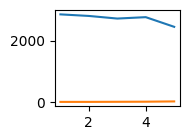

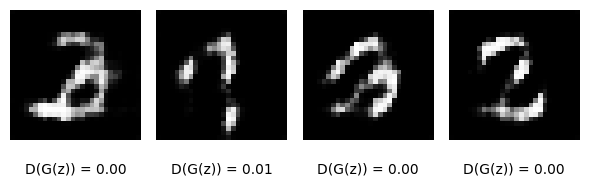

[6] Generator loss: 2161.4790003299713
[6] Discriminator loss: 28.00003787316382
[7] Generator loss: 1975.287825345993
[7] Discriminator loss: 40.77894072420895
[8] Generator loss: 1888.9980815649033
[8] Discriminator loss: 58.127916522324085
[9] Generator loss: 1699.5385965108871
[9] Discriminator loss: 70.36108633130789
[10] Generator loss: 1542.4836065769196
[10] Discriminator loss: 82.04495771229267
[10]


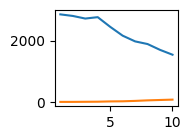

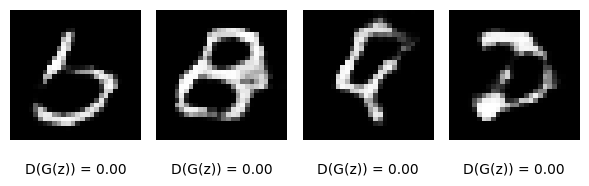

[11] Generator loss: 1509.0465629696846
[11] Discriminator loss: 89.05727809667587
[12] Generator loss: 1456.8604009151459
[12] Discriminator loss: 109.20233506709337
[13] Generator loss: 1251.5438793897629
[13] Discriminator loss: 118.29119022190571
[14] Generator loss: 1197.5655487775803
[14] Discriminator loss: 119.0600771382451
[15] Generator loss: 1260.7230501174927
[15] Discriminator loss: 114.38337181508541
[15]


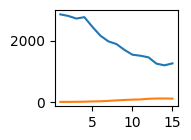

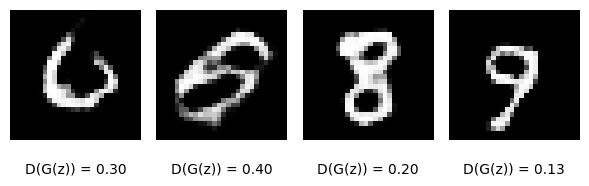

[16] Generator loss: 1189.5734865665436
[16] Discriminator loss: 113.87672628462315
[17] Generator loss: 1220.6905716657639
[17] Discriminator loss: 119.18048802763224
[18] Generator loss: 1201.1517775058746
[18] Discriminator loss: 119.30855175107718
[19] Generator loss: 1189.6285189390182
[19] Discriminator loss: 134.41284082084894
[20] Generator loss: 1093.9648884534836
[20] Discriminator loss: 119.30590665340424
[20]


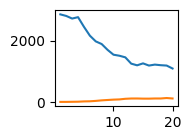

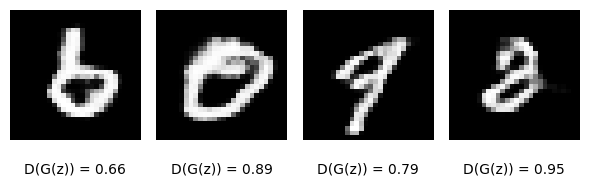

[21] Generator loss: 1132.8703573942184
[21] Discriminator loss: 123.04284499585629
[22] Generator loss: 1152.287854373455
[22] Discriminator loss: 135.6961037144065
[23] Generator loss: 1070.999932050705
[23] Discriminator loss: 137.96770115941763
[24] Generator loss: 1016.0831171870232
[24] Discriminator loss: 130.73165479302406
[25] Generator loss: 1052.4356172084808
[25] Discriminator loss: 134.98598296940327
[25]


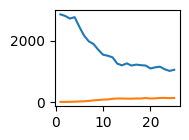

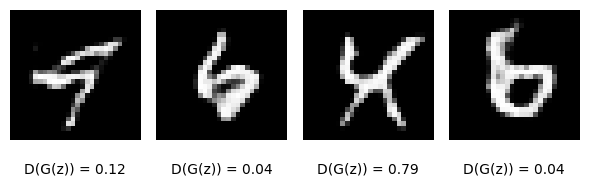

[26] Generator loss: 1056.5196442008018
[26] Discriminator loss: 140.7899245992303
[27] Generator loss: 1117.1974281072617
[27] Discriminator loss: 143.6988582983613
[28] Generator loss: 1102.4337894320488
[28] Discriminator loss: 151.2419005408883
[29] Generator loss: 971.557276070118
[29] Discriminator loss: 155.4250402227044
[30] Generator loss: 977.2274530529976
[30] Discriminator loss: 149.9810627400875
[30]


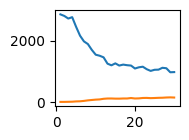

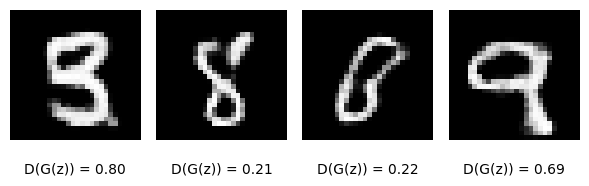

[31] Generator loss: 941.8653742671013
[31] Discriminator loss: 149.27021956443787
[32] Generator loss: 948.7027004361153
[32] Discriminator loss: 147.0199160426855
[33] Generator loss: 986.0196564793587
[33] Discriminator loss: 149.68872551620007
[34] Generator loss: 950.0506067872047
[34] Discriminator loss: 152.5105383992195
[35] Generator loss: 1011.3654889166355
[35] Discriminator loss: 163.72496081143618
[35]


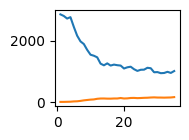

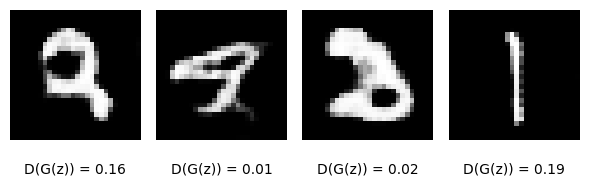

[36] Generator loss: 904.968743801117
[36] Discriminator loss: 156.17061191797256
[37] Generator loss: 975.6903678774834
[37] Discriminator loss: 157.2857648730278
[38] Generator loss: 931.5513293743134
[38] Discriminator loss: 159.65069511532784
[39] Generator loss: 929.6290078163147
[39] Discriminator loss: 156.9474567770958
[40] Generator loss: 906.6817877292633
[40] Discriminator loss: 152.78828677535057
[40]


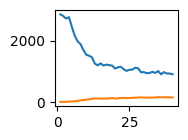

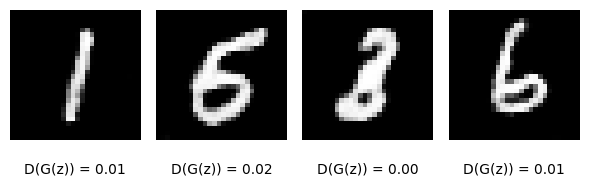

[41] Generator loss: 884.4836860895157
[41] Discriminator loss: 152.66014637053013
[42] Generator loss: 921.9393377900124
[42] Discriminator loss: 153.989605627954
[43] Generator loss: 944.8245237469673
[43] Discriminator loss: 162.49957348406315
[44] Generator loss: 954.1650647521019
[44] Discriminator loss: 161.26437509059906
[45] Generator loss: 942.3578176498413
[45] Discriminator loss: 156.66171096265316
[45]


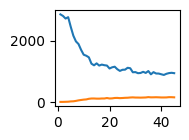

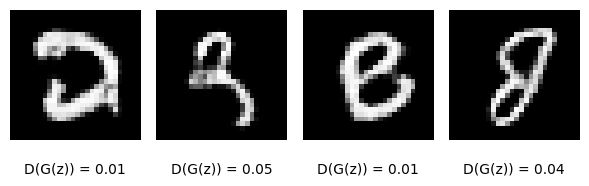

[46] Generator loss: 868.1405537724495
[46] Discriminator loss: 159.96098136901855
[47] Generator loss: 897.0124870538712
[47] Discriminator loss: 155.29051712155342
[48] Generator loss: 931.0272904634476
[48] Discriminator loss: 153.59498681128025
[49] Generator loss: 1027.5690989494324
[49] Discriminator loss: 152.1727754920721
[50] Generator loss: 929.1927323937416
[50] Discriminator loss: 159.55346815288067
[50]


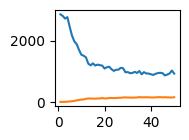

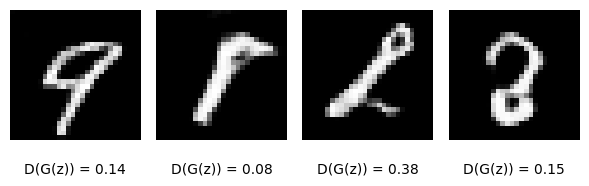

[51] Generator loss: 868.1984773874283
[51] Discriminator loss: 155.29806898534298
[52] Generator loss: 887.7203361988068
[52] Discriminator loss: 146.89838322997093
[53] Generator loss: 919.7840803861618
[53] Discriminator loss: 147.19502387940884
[54] Generator loss: 930.4148733019829
[54] Discriminator loss: 149.6962347626686
[55] Generator loss: 963.1175459623337
[55] Discriminator loss: 148.76772092282772
[55]


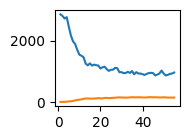

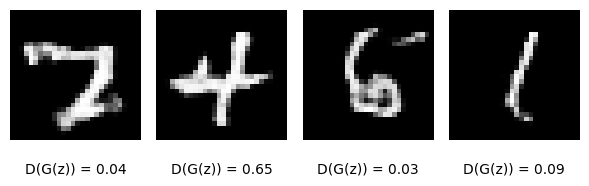

[56] Generator loss: 922.1198278665543
[56] Discriminator loss: 146.11257813870907
[57] Generator loss: 927.0428701639175
[57] Discriminator loss: 149.25802383571863
[58] Generator loss: 938.4518809318542
[58] Discriminator loss: 140.32677786052227
[59] Generator loss: 893.7329481244087
[59] Discriminator loss: 142.6737861931324
[60] Generator loss: 961.8434920310974
[60] Discriminator loss: 141.75563448667526
[60]


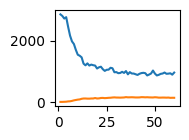

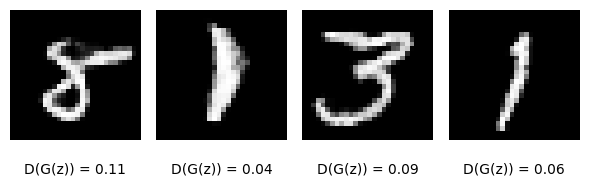

[61] Generator loss: 988.5238888263702
[61] Discriminator loss: 143.77617709338665
[62] Generator loss: 949.8881651163101
[62] Discriminator loss: 144.58565206080675
[63] Generator loss: 926.0452013015747
[63] Discriminator loss: 138.66233392059803
[64] Generator loss: 926.0033602714539
[64] Discriminator loss: 132.0195818990469
[65] Generator loss: 940.3316851258278
[65] Discriminator loss: 131.7066731005907
[65]


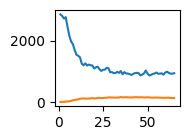

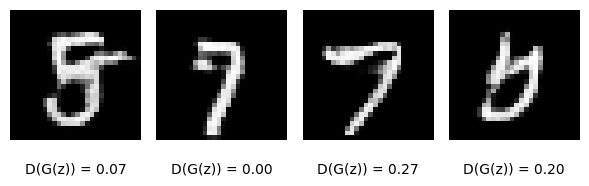

[66] Generator loss: 977.2410207986832
[66] Discriminator loss: 130.3849863409996
[67] Generator loss: 995.6343251466751
[67] Discriminator loss: 131.96109227091074
[68] Generator loss: 990.5542286634445
[68] Discriminator loss: 139.44175592064857
[69] Generator loss: 987.0292840600014
[69] Discriminator loss: 138.347859762609
[70] Generator loss: 972.1477618217468
[70] Discriminator loss: 130.4254292845726
[70]


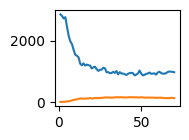

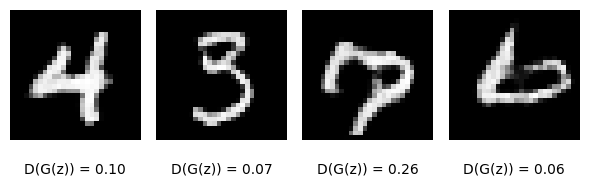

[71] Generator loss: 971.5710468888283
[71] Discriminator loss: 131.50183811038733
[72] Generator loss: 991.7901312112808
[72] Discriminator loss: 131.5619335025549
[73] Generator loss: 983.6888917684555
[73] Discriminator loss: 137.1583044230938
[74] Generator loss: 969.2841057777405
[74] Discriminator loss: 127.78761521726847
[75] Generator loss: 962.5093931555748
[75] Discriminator loss: 128.9100717306137
[75]


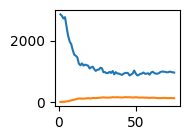

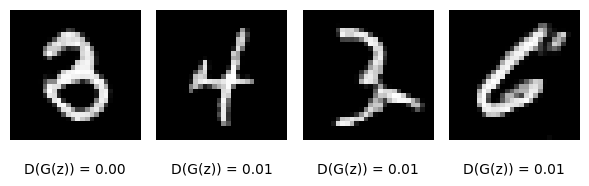

[76] Generator loss: 1020.8140078783035
[76] Discriminator loss: 132.76730035245419
[77] Generator loss: 984.4963225126266
[77] Discriminator loss: 127.26041500270367
[78] Generator loss: 992.7121807932854
[78] Discriminator loss: 126.23041478544474
[79] Generator loss: 1007.128559589386
[79] Discriminator loss: 126.36898661404848
[80] Generator loss: 1014.5974253416061
[80] Discriminator loss: 127.54453702270985
[80]


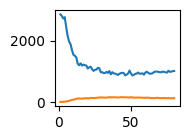

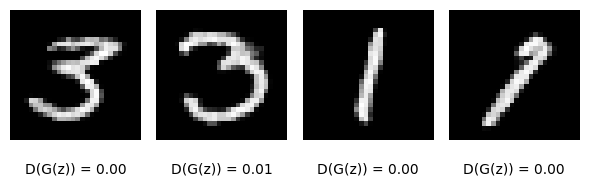

[81] Generator loss: 997.0924986600876
[81] Discriminator loss: 126.18704034388065
[82] Generator loss: 983.9233333468437
[82] Discriminator loss: 120.28907503187656
[83] Generator loss: 1007.4891709685326
[83] Discriminator loss: 125.89527194947004
[84] Generator loss: 1020.2883724570274
[84] Discriminator loss: 122.41103398054838
[85] Generator loss: 1015.6757160425186
[85] Discriminator loss: 117.57295998185873
[85]


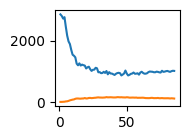

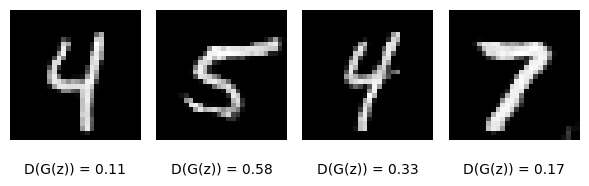

[86] Generator loss: 1028.6974536776543
[86] Discriminator loss: 122.21446182578802
[87] Generator loss: 1054.8326679468155
[87] Discriminator loss: 120.60965783894062
[88] Generator loss: 1020.5636222958565
[88] Discriminator loss: 122.37589967995882
[89] Generator loss: 1003.9486949443817
[89] Discriminator loss: 112.35564927756786
[90] Generator loss: 1056.0057584643364
[90] Discriminator loss: 113.9495108127594
[90]


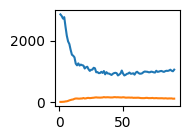

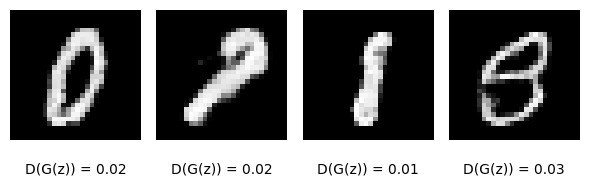

[91] Generator loss: 1116.4916070103645
[91] Discriminator loss: 120.37978913635015
[92] Generator loss: 1046.7800273895264
[92] Discriminator loss: 115.27618349343538
[93] Generator loss: 1038.8633583188057
[93] Discriminator loss: 111.03611579537392
[94] Generator loss: 1049.7698942422867
[94] Discriminator loss: 109.45883905142546
[95] Generator loss: 1071.1198353767395
[95] Discriminator loss: 110.53521889448166
[95]


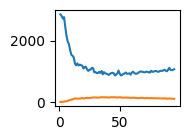

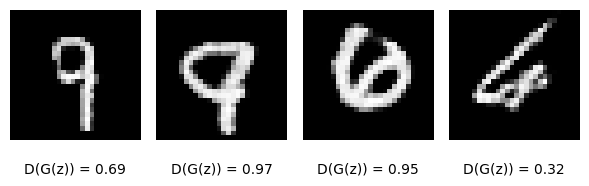

[96] Generator loss: 1097.688039958477
[96] Discriminator loss: 121.66994508355856
[97] Generator loss: 1059.416481077671
[97] Discriminator loss: 113.0284928381443
[98] Generator loss: 1069.5365671515465
[98] Discriminator loss: 107.86172340065241
[99] Generator loss: 1083.424068748951
[99] Discriminator loss: 114.04338009655476
[100] Generator loss: 1093.918305337429
[100] Discriminator loss: 106.71507333219051
[100]


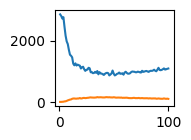

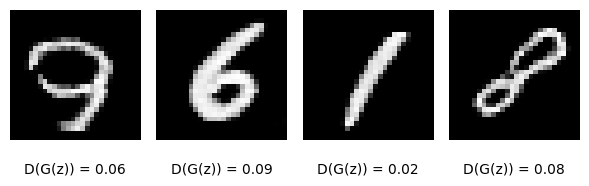

In [239]:
if __name__ == '__main__':
  g_net, d_net = train()

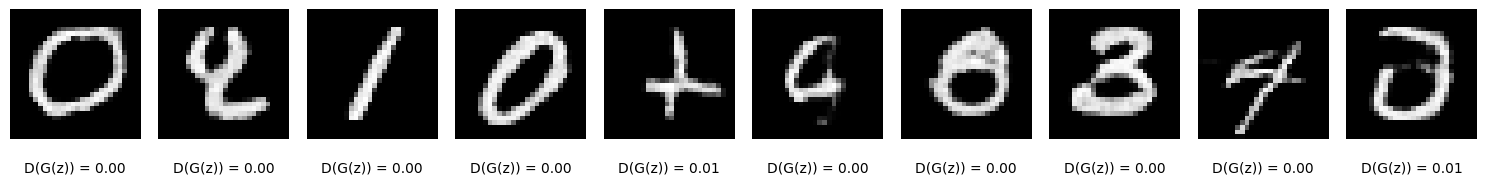

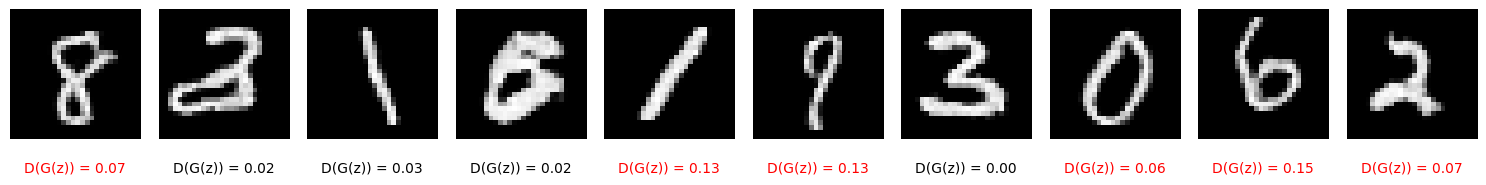

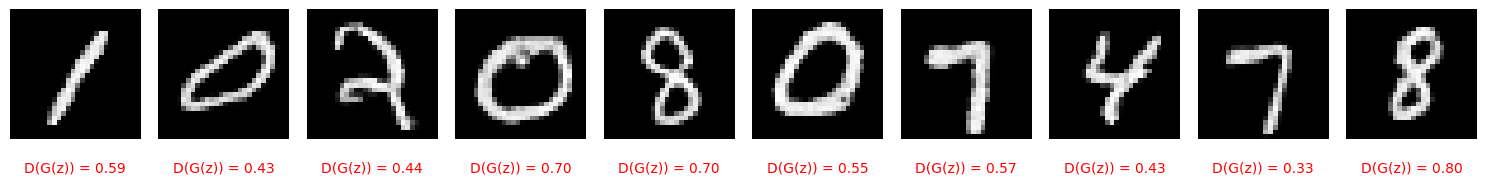

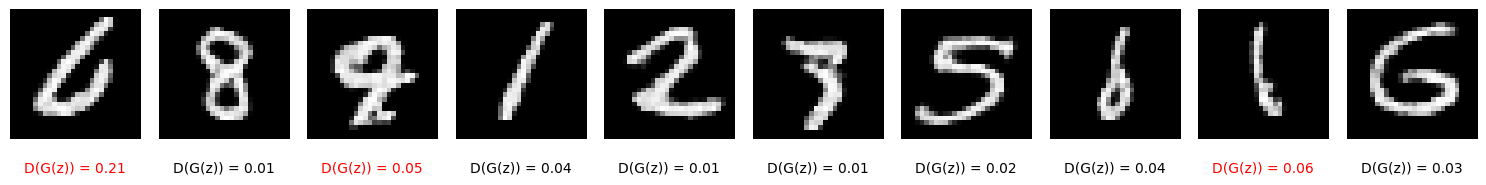

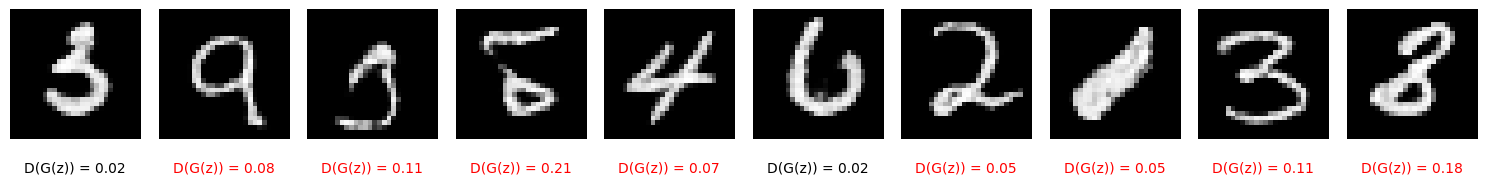

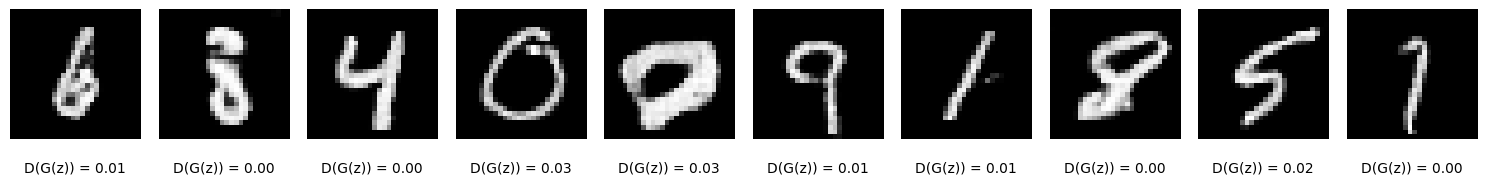

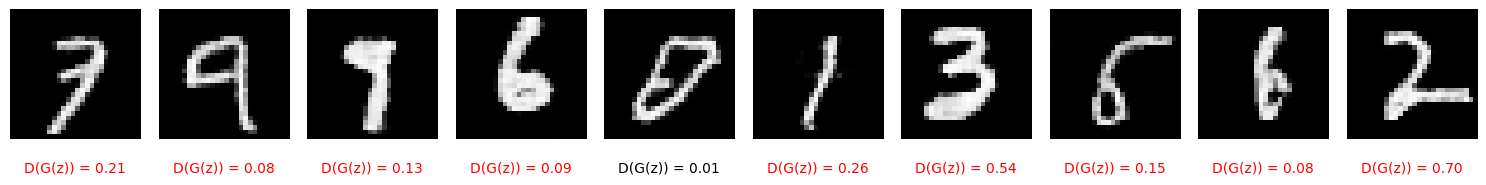

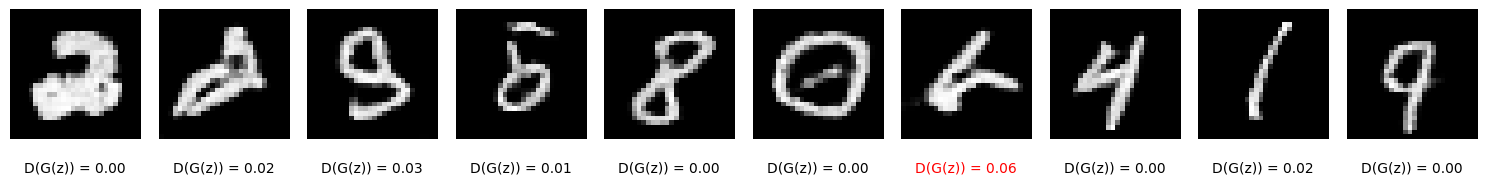

In [248]:
@torch.no_grad()
def visualize_final(z_dim=100, n=1, g_net_=None, d_net_=None, threshold=0.05):
  assert g_net_ is not None and d_net_ is not None
  def sample_fake(m):
    z = torch.randn(m, z_dim, 1, 1, device=device)
    return g_net_(z)
  x_fake = sample_fake(n)
  scores = d_net_(x_fake)
  fig, ax = plt.subplots(1, n, figsize=(1.5 * n, 2))
  for i, x in enumerate(x_fake):
    img = x.cpu().permute(1, 2, 0)
    score = scores[i].cpu().item()
    ax[i].axis('off')
    ax[i].imshow(img, cmap='grey')
    ax[i].text(0.5, -0.25, f'D(G(z)) = {score:.2f}', color=('red' if score > threshold else 'black'), transform=ax[i].transAxes, ha='center')
  plt.tight_layout()
  plt.show()

threshold = 0.05
visualize_final(n=10, g_net_=g_net, d_net_=d_net, threshold=threshold)
visualize_final(n=10, g_net_=g_net, d_net_=d_net, threshold=threshold)
visualize_final(n=10, g_net_=g_net, d_net_=d_net, threshold=threshold)
visualize_final(n=10, g_net_=g_net, d_net_=d_net, threshold=threshold)
visualize_final(n=10, g_net_=g_net, d_net_=d_net, threshold=threshold)
visualize_final(n=10, g_net_=g_net, d_net_=d_net, threshold=threshold)
visualize_final(n=10, g_net_=g_net, d_net_=d_net, threshold=threshold)
visualize_final(n=10, g_net_=g_net, d_net_=d_net, threshold=threshold)